###Import


In [ ]:
#Imports

import warnings
warnings.filterwarnings('ignore')

#modelling

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization
from keras import backend as K
from keras import regularizers
from keras import layers, losses
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split

# tf.logging.set_verbosity(tf.logging.ERROR)

#plotting
import matplotlib.pyplot as plt
%matplotlib inline

#dataset
from keras.datasets import mnist
import numpy as np
import pandas as pd

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1hhe-17dRtp9pzY0kv0852FF48AHhzn-G' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1hhe-17dRtp9pzY0kv0852FF48AHhzn-G" -O RSData.zip && rm -rf /tmp/cookies.txt
# https://drive.google.com/file/d/1hhe-17dRtp9pzY0kv0852FF48AHhzn-G/view?usp=sharing
#https://drive.google.com/file/d/1hhe-17dRtp9pzY0kv0852FF48AHhzn-G/view?usp=sharing

!unzip RSData.zip

--2023-10-25 07:10:58--  https://docs.google.com/uc?export=download&confirm=t&id=1hhe-17dRtp9pzY0kv0852FF48AHhzn-G
Resolving docs.google.com (docs.google.com)... 142.251.12.113, 142.251.12.100, 142.251.12.138, ...
Connecting to docs.google.com (docs.google.com)|142.251.12.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-44-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7mr9mttog5s0eqbh2rggmnp33kg0a5dp/1698217800000/07988131849474548919/*/1hhe-17dRtp9pzY0kv0852FF48AHhzn-G?e=download&uuid=7f2a50a5-8ec3-4145-bc55-525287f46c81 [following]
--2023-10-25 07:10:59--  https://doc-0g-44-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7mr9mttog5s0eqbh2rggmnp33kg0a5dp/1698217800000/07988131849474548919/*/1hhe-17dRtp9pzY0kv0852FF48AHhzn-G?e=download&uuid=7f2a50a5-8ec3-4145-bc55-525287f46c81
Resolving doc-0g-44-docs.googleusercontent.com (doc-0g-44-docs.googleusercontent.com)... 74.125.130.132, 

In [ ]:
useritem = pd.read_csv("/content/user_item.csv")
usertag = pd.read_csv("/content/user_tag.csv")
useruser = pd.read_csv("/content/user_user.csv")

In [ ]:
# user = useritem.copy()
# row_slice = slice(user.shape[0]-200,user.shape[1]-1)
# col_slice = slice(user.shape[0]-200,user.shape[1])
# train_data = user
# train_data.loc[row_slice, col_slice] = 0
# test_data = user - train_data

In [ ]:
useruser = useruser.to_numpy()
usertag = usertag.to_numpy()
useritem = useritem.to_numpy()
# usertrain_data = train_data.to_numpy()
# usertest_data = test_data.to_numpy()

####Dictionary

In [ ]:
user_friends = pd.read_csv('/content/hetrec2011-lastfm-2k/user_friends.csv')
pivot_table = user_friends.pivot_table(index=['userID'], columns='friendID', aggfunc='size', fill_value=0)
user_friends_df = pivot_table
useruser_dict = {i+1: index for i, index in enumerate(user_friends_df.index)}

In [ ]:
user_tagged = pd.read_csv("/content/hetrec2011-lastfm-2k/user_taggedartists.csv")
pivot_table = user_tagged.pivot_table(index=['userID'], columns='tagID', aggfunc = 'size').fillna(0)
user_tag_df = pivot_table
usertag_dict = {i+1: index for i, index in enumerate(user_tag_df.index)}

In [ ]:
user_item = pd.read_csv("/content/hetrec2011-lastfm-2k/user_taggedartists.csv")
pivot_table = user_item.pivot_table(index=['userID'], columns='artistID', aggfunc = 'size').fillna(0)
user_item_df = pivot_table
useritem_dict = {i+1: index for i, index in enumerate(user_item_df.index)}

###EDA

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [ ]:
# import our files
plays = pd.read_csv('/content/hetrec2011-lastfm-2k/user_artists.dat',sep='\t')
artists = pd.read_csv('/content/hetrec2011-lastfm-2k/artists.dat',sep='\t',usecols=['id','name'])

# we import to understand what datapoints we have, but do not use these
# in our collaborative engine
tags = pd.read_csv('/content/hetrec2011-lastfm-2k/tags.dat', sep='\t',encoding='latin-1')
uta = pd.read_csv('/content/hetrec2011-lastfm-2k/user_taggedartists.csv')
utat = pd.read_csv('/content/hetrec2011-lastfm-2k/user_friends.csv', sep="\t")
friends = pd.read_csv('/content/hetrec2011-lastfm-2k/user_friends.dat', sep='\t')

In [ ]:
# create a function to provide various statistics on our data files
def print_info(df_list, df_name):

    assert len(df_list) == len(df_name)

    for i in range(len(df_list)):
        print(df_name[i],'\n')
        print("Shape: {}\n".format(df_list[i].shape))
        print("Info:")
        print(df_list[i].info(),'\n')
        print("Unique:\n{}\n".format(df_list[i].nunique()))

        print("No duplicates: {}\n".format(len(df_list[i])==len(df_list[i].drop_duplicates())))

In [ ]:
df_list = [plays, artists, tags, uta, utat, friends]
df_name = ['**Plays**',
           '**Artists**',
           '**Tags**',
           '**User Tagged Artists (Date)**',
           '**User Tagged Artists (Timestamp)**',
           '**Friends**']

print_info(df_list,df_name)

**Plays** 

Shape: (92834, 3)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92834 entries, 0 to 92833
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userID    92834 non-null  int64
 1   artistID  92834 non-null  int64
 2   weight    92834 non-null  int64
dtypes: int64(3)
memory usage: 2.1 MB
None 

Unique:
userID       1892
artistID    17632
weight       5436
dtype: int64

No duplicates: True

**Artists** 

Shape: (17632, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17632 entries, 0 to 17631
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17632 non-null  int64 
 1   name    17632 non-null  object
dtypes: int64(1), object(1)
memory usage: 275.6+ KB
None 

Unique:
id      17632
name    17632
dtype: int64

No duplicates: True

**Tags** 

Shape: (11946, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 0 to 1

In [ ]:
ap = pd.merge(artists,
                plays,
                how='inner',
                left_on='id',
                right_on='artistID')

ap = ap.rename(columns={"weight":"userArtistPlays"})

ap.head()

,id,name,userID,artistID,userArtistPlays
0,1,MALICE MIZER,34,1,212
1,1,MALICE MIZER,274,1,483
2,1,MALICE MIZER,785,1,76
3,2,Diary of Dreams,135,2,1021
4,2,Diary of Dreams,257,2,152


In [ ]:
artist_rank = (ap.groupby(['name']).agg({'userID':'count','userArtistPlays':'sum'}).
    rename(columns={"userID":'totalUniqueUsers',"userArtistPlays":"totalArtistPlays"}).
              sort_values(['totalArtistPlays'],ascending=False))

artist_rank['avgUserPlays'] = artist_rank['totalArtistPlays']/artist_rank['totalUniqueUsers']
user_rank = (ap.groupby(['userID']).agg({'name':'count','userArtistPlays':'sum'}).
    rename(columns={"name":'totalUniqueArtists',"userArtistPlays":"totalUserPlays"}).
            sort_values(['totalUserPlays'],ascending=False))

In [ ]:
# Britney Spears is the most played at 2.4 million plays
artist_rank.head()

,totalUniqueUsers,totalArtistPlays,avgUserPlays
name,,,
Britney Spears,522,2393140,4584.559387
Depeche Mode,282,1301308,4614.567376
Lady Gaga,611,1291387,2113.563011
Christina Aguilera,407,1058405,2600.503686
Paramore,399,963449,2414.659148


In [ ]:
artist_rank.describe()

,totalUniqueUsers,totalArtistPlays,avgUserPlays
count,17632.000000,1.763200e+04,17632.000000
mean,5.265086,3.923774e+03,423.777052
std,20.620315,3.409934e+04,785.379277
min,1.000000,1.000000e+00,1.000000
25%,1.000000,1.130000e+02,97.000000
50%,1.000000,3.500000e+02,246.000000
75%,3.000000,1.234250e+03,496.875000
max,611.000000,2.393140e+06,35323.000000


Per the total artist plays column we see an average of almost 4,000 plays per artist with a max of 2.4 million (for Britney Spears).



In [ ]:
user_rank.head()

,totalUniqueArtists,totalUserPlays
userID,,
757,50,480039
2000,50,468409
1418,50,416349
1642,50,388251
1094,50,379125


Here we have our top users in terms of total play count. We also see an apparent cap of 50 artists per user.

In [ ]:
ap2 = ap.join(artist_rank,on='name',how='inner')
ap3 = ap2.join(user_rank,on='userID',how='inner').sort_values(['userArtistPlays'],ascending=False)

# confirm no duplicated rows
assert ap3[ap3.duplicated(['userID','name'])].empty

In [ ]:
ap3.head()

,id,name,userID,artistID,userArtistPlays,totalUniqueUsers,totalArtistPlays,avgUserPlays,totalUniqueArtists,totalUserPlays
2800,72,Depeche Mode,1642,72,352698,282,1301308,4614.567376,50,388251
35843,792,Thalía,2071,792,324663,26,350035,13462.884615,50,338400
27302,511,U2,1094,511,320725,185,493024,2664.994595,50,379125
8152,203,Blur,1905,203,257978,114,318221,2791.412281,50,276295
26670,498,Paramore,1664,498,227829,399,963449,2414.659148,50,251560


In [ ]:
print_info([ap3[['userID','artistID']]],['***Artist Plays***'])

***Artist Plays*** 

Shape: (92834, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 92834 entries, 2800 to 88660
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userID    92834 non-null  int64
 1   artistID  92834 non-null  int64
dtypes: int64(2)
memory usage: 2.1 MB
None 

Unique:
userID       1892
artistID    17632
dtype: int64

No duplicates: True



*   17,632 unique artist ID and name
*   1,892 unique user ID
*   92,834 total data points (artist/user pairs)


In [ ]:
# 69 million total plays
print("{:,}".format(ap3['userArtistPlays'].sum()))

69,183,975


In [ ]:
# our standard bar chart in a function below

def bar_chart_int(x,y,x_label,y_label,title,caption,total_val):
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 5)
    ax = sns.barplot(x = x[:20],y = y[:20])
    ax.set_xlabel(x_label,fontweight='bold')
    ax.set_ylabel(y_label,fontweight='bold')
    ax.set_title(title,fontweight='bold')
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x))))

    # our bar label placement
    for p in ax.patches:
        height = p.get_height()
        pct = 100*(height/total_val)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.1f}%'.format(pct),
                ha="center",verticalalignment='bottom',color='black')

    # our caption statement
    ax.text(19, max(y[:20])*0.95, caption, style='italic',fontsize=12,horizontalalignment='right')

    plt.xticks(rotation=90)
    plt.show()

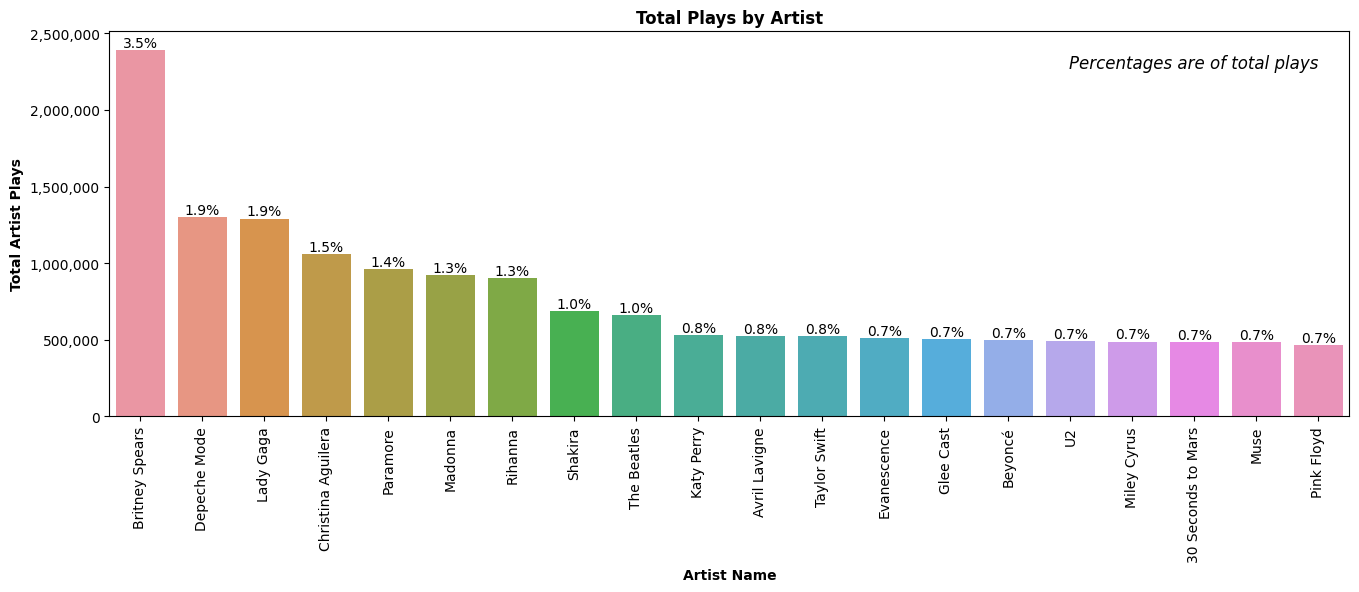

In [ ]:
c1 = artist_rank
x = c1.index
y = c1.totalArtistPlays
x_label = 'Artist Name'
y_label = 'Total Artist Plays'
title = 'Total Plays by Artist'
caption = 'Percentages are of total plays'
total_val = c1.totalArtistPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

With 2.4 million plays out of a aggregate play count of 69 million in the dataset, Britney Spears received 3.5% of the plays in the dataset.


In [ ]:
artist_rank.sort_values(['totalUniqueUsers'],ascending=False).head()

,totalUniqueUsers,totalArtistPlays,avgUserPlays
name,,,
Lady Gaga,611,1291387,2113.563011
Britney Spears,522,2393140,4584.559387
Rihanna,484,905423,1870.708678
The Beatles,480,662116,1379.408333
Katy Perry,473,532545,1125.887949


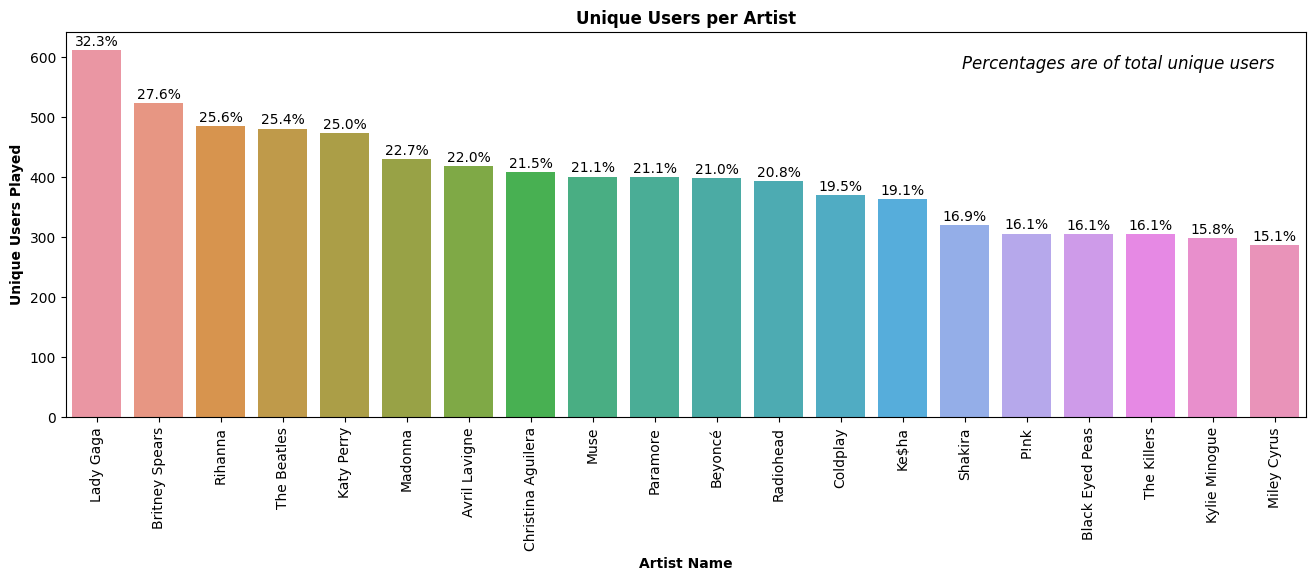

In [ ]:
c2 = artist_rank.sort_values(['totalUniqueUsers'],ascending=False)
x = c2.index
y = c2.totalUniqueUsers
x_label = 'Artist Name'
y_label = 'Unique Users Played'
title = 'Unique Users per Artist'
caption = 'Percentages are of total unique users'
total_val = ap3.userID.nunique()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

Of the total 1,892 users in this dataset, 611 of them listened to Lady Gaga at least one time. That is 32.3% of all users!

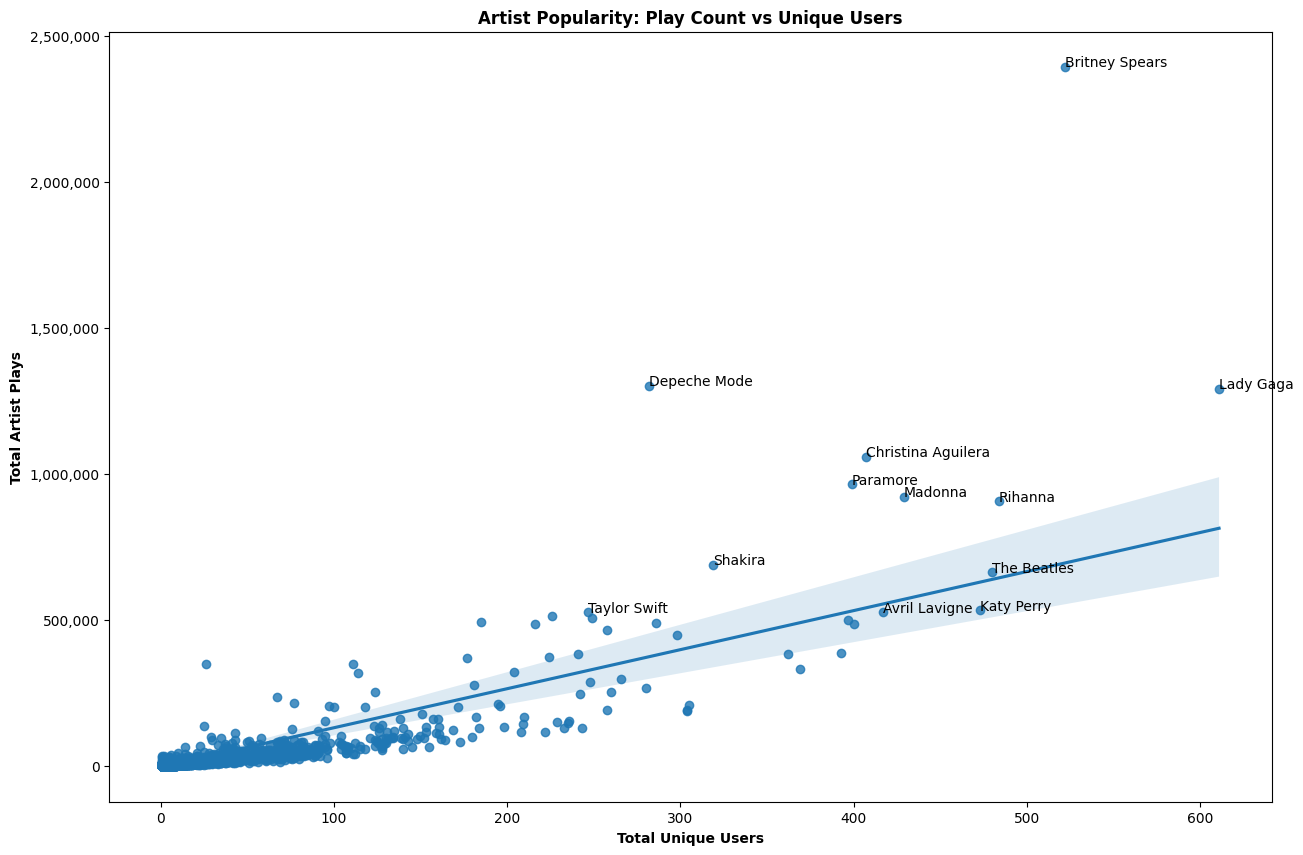

In [ ]:
top_artists = artist_rank.sort_values(['totalArtistPlays'],ascending=False).index[:12]

x = artist_rank.totalUniqueUsers
y = artist_rank.totalArtistPlays
labels = artist_rank.index

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x = x,y =y)
ax.set_title('Artist Popularity: Play Count vs Unique Users',fontweight='bold')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))
ax.set_xlabel('Total Unique Users',fontweight='bold')
ax.set_ylabel('Total Artist Plays',fontweight='bold')

for i, t in enumerate(labels):
    if t in top_artists:
        ax.annotate(t,(x[i],y[i]))

we see general positive correlation between number of artist plays and number of unique users. We see Britney Spears with the most aggregate plays and Lady Gaga with the most unique listeners.

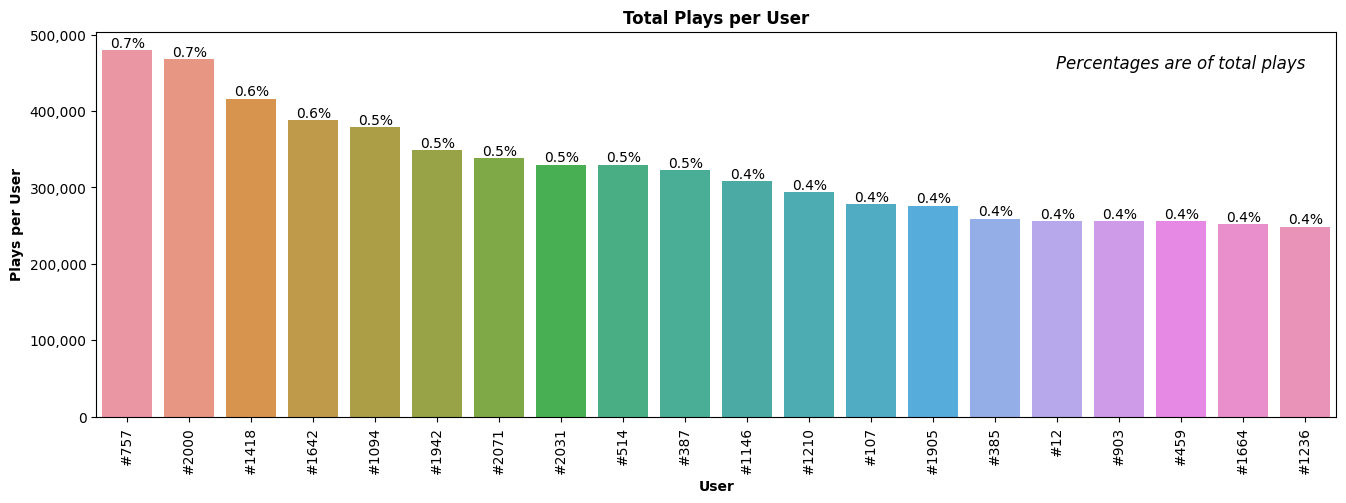

In [ ]:
c3 = user_rank.sort_values(['totalUserPlays'],ascending=False)
c3['userID'] = c3.index
c3.userID = c3.userID.apply(lambda x: '#'+str(x))

x = c3.userID
y = c3.totalUserPlays
x_label = 'User'
y_label = 'Plays per User'
title = 'Total Plays per User'
caption = 'Percentages are of total plays'
total_val = ap3.userArtistPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

User #757 accounts for almost 1% of all plays in the dataset with almost 500,000 plays.

In [ ]:
artist_rank.sort_values(['avgUserPlays'],ascending=False).head()

,totalUniqueUsers,totalArtistPlays,avgUserPlays
name,,,
Viking Quest,1,35323,35323.0
Tyler Adam,1,30614,30614.0
Rytmus,1,23462,23462.0
Johnny Hallyday,2,32995,16497.5
Dicky Dixon,1,15345,15345.0


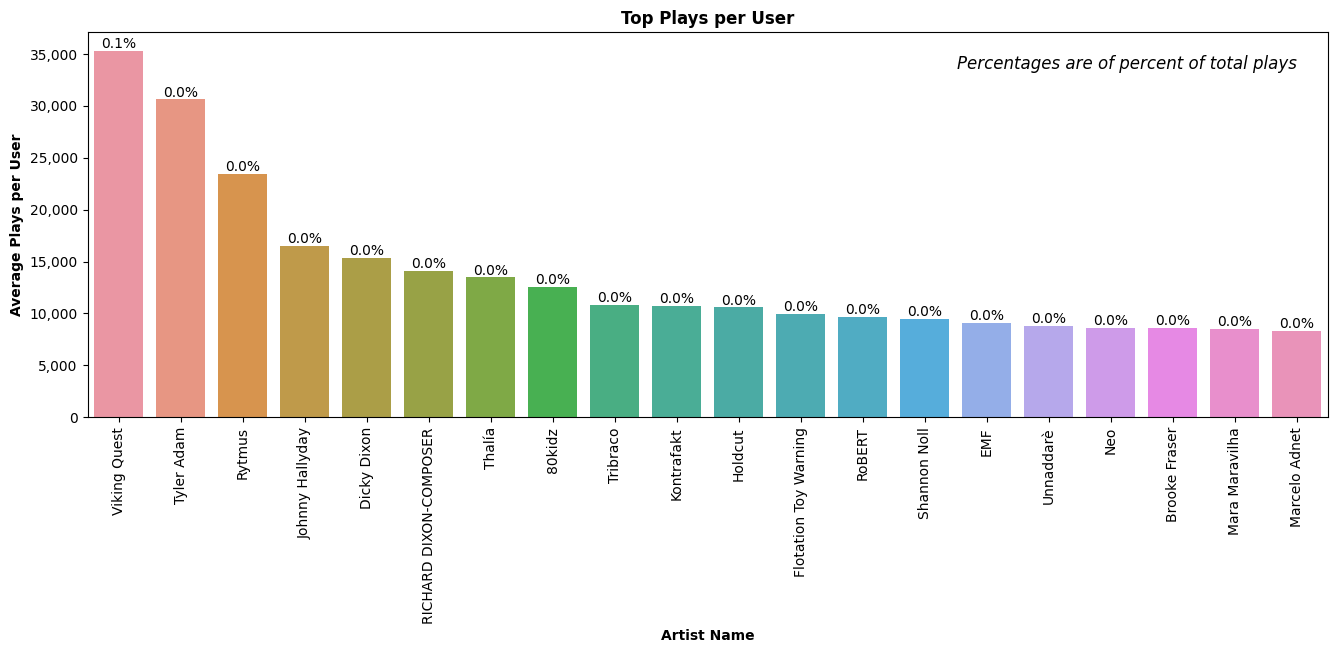

In [ ]:
c4 = artist_rank.sort_values(['avgUserPlays'],ascending=False)

x = c4.index
y = c4.avgUserPlays
x_label = 'Artist Name'
y_label = 'Average Plays per User'
title = 'Top Plays per User'
caption = 'Percentages are of percent of total plays'
total_val = ap3.userArtistPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

Viking Quest has a single unique user which played them 35,000 times.

###Sparse

####Train Test Split

In [ ]:
userusertrain, userusertest, useritemtrain, useritemtest, usertagtrain, usertagtest = train_test_split(useruser, useritem, usertag, test_size = 0.0000001, shuffle = False)

# userusertrain, userusertest, useritemtrain, useritemtest, usertagtrain, usertagtest = train_test_split(useruser, useritem, usertag, test_size = 0.0155562368, shuffle = False)

In [ ]:
userusertrain.shape, userusertest.shape

((1891, 1892), (1, 1892))

In [ ]:
useritemtrain.shape, useritemtest.shape

((1891, 12523), (1, 12523))

In [ ]:
usertagtrain.shape, usertagtest.shape

((1891, 9749), (1, 9749))

####Usertag:

In [ ]:
# Layer 1
input_img = Input(shape = (usertagtrain.shape[1],))
encoded1 = Dense(1000, activation = 'relu')(input_img)
encoded1_bn = BatchNormalization()(encoded1)
decoded1 = Dense(usertagtrain.shape[1], activation = 'relu')(encoded1_bn)

autoencoder1 = Model(input_img, decoded1)
encoder1 = Model(input_img, encoded1)

# Layer 2
encoded1_input = Input(shape = (1000,))
# distorted_input2 = Dropout(.2)(encoded1_input)
encoded2 = Dense(800, activation = 'relu')(encoded1_input)
encoded2_bn = BatchNormalization()(encoded2)
decoded2 = Dense(1000, activation = 'relu')(encoded2_bn)

autoencoder2 = Model(encoded1_input, decoded2)
encoder2 = Model(encoded1_input, encoded2)

# Layer 3 - which we won't end up fitting in the interest of time
encoded2_input = Input(shape = (800,))
# distorted_input3 = Dropout(.3)(encoded2_input)
encoded3 = Dense(400, activation = 'relu',activity_regularizer=keras.regularizers.L1(0.0001))(encoded2_input)
encoded3_bn = BatchNormalization()(encoded3)
decoded3 = Dense(800, activation = 'relu')(encoded3_bn)

autoencoder3 = Model(encoded2_input, decoded3)
encoder3 = Model(encoded2_input, encoded3)
sgd1 = SGD(learning_rate = 0.08, momentum = .85, nesterov = True)
sgd2 = SGD(learning_rate = 0.08, momentum = .85, nesterov = True)
sgd3 = SGD(learning_rate = 0.08, momentum = .85, nesterov = True)

autoencoder1.compile(loss='mse', optimizer = sgd1)
autoencoder2.compile(loss='mse', optimizer = sgd2)
autoencoder3.compile(loss='mse', optimizer = sgd3)

encoder1.compile(loss='mse', optimizer = sgd1)
encoder2.compile(loss='mse', optimizer = sgd1)
encoder3.compile(loss='mse', optimizer = sgd1)

autoencoder1.fit(usertagtrain, usertagtrain, epochs = 50, batch_size = 64)
first_layer_code = encoder1.predict(usertagtrain)
print(first_layer_code.shape)

autoencoder2.fit(first_layer_code, first_layer_code,
                epochs = 50, batch_size = 64)
second_layer_code = encoder2.predict(first_layer_code)
print(second_layer_code.shape)

autoencoder3.fit(second_layer_code, second_layer_code,
               epochs = 50, batch_size = 64)
third_layer_code = encoder3.predict(second_layer_code)
print(third_layer_code.shape)

Epoch 1/50
30/30 [==============================] - 1s 12ms/step - loss: 0.0282
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.0168
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.0105
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.0073
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.0055
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.0045
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.0038
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.0033
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.0029
Epoch 10/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0026
Epoch 11/50
30/30 [==============================] - 0s 11ms/step - loss: 0.0024
Epoch 12/50
30/30 [==============================] - 0s 11ms/step - loss: 0.0022
Epoch 13/50
30/30 [==================

In [ ]:
# Deep Autoencoder
encoded1_da = Dense(1000, activation = 'relu')(input_img)
encoded1_da_bn = BatchNormalization()(encoded1_da)
encoded2_da = Dense(800, activation = 'relu')(encoded1_da_bn)
encoded2_da_bn = BatchNormalization()(encoded2_da)
encoded3_da = Dense(400, activation = 'relu',activity_regularizer=keras.regularizers.L1(0.0001))(encoded2_da_bn)
# encoded3_da_bn = BatchNormalization()(encoded3_da)
# decoded3_da = Dense(800, activation = 'relu')(encoded3_da_bn)
# decoded2_da = Dense(1000, activation = 'relu')(decoded3_da)
# decoded1_da = Dense(usertag.shape[1], activation = 'sigmoid')(decoded2_da)

deep_autoencoder = Model(input_img, encoded3_da)
# Setting the weights of the deep autoencoder
deep_autoencoder.layers[1].set_weights(autoencoder1.layers[1].get_weights()) # first dense layer
deep_autoencoder.layers[2].set_weights(autoencoder1.layers[2].get_weights()) # first bn layer
deep_autoencoder.layers[3].set_weights(autoencoder2.layers[1].get_weights()) # second dense layer
deep_autoencoder.layers[4].set_weights(autoencoder2.layers[2].get_weights()) # second bn layer
deep_autoencoder.layers[5].set_weights(autoencoder3.layers[1].get_weights()) # third dense layer
# deep_autoencoder.layers[6].set_weights(autoencoder3.layers[3].get_weights()) # third bn layer
# deep_autoencoder.layers[7].set_weights(autoencoder3.layers[4].get_weights()) # first decoder
# deep_autoencoder.layers[8].set_weights(autoencoder2.layers[4].get_weights()) # second decoder
# deep_autoencoder.layers[9].set_weights(autoencoder1.layers[3].get_weights()) # third decoder

In [ ]:
usertagk = deep_autoencoder.predict(usertag)

60/60 [==============================] - 0s 2ms/step


In [ ]:
usertagk.shape

(1892, 400)

In [ ]:
usertagk

array([[0.0051201 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.19048852, 0.        , 0.        , ..., 2.2336438 , 0.        ,
        1.0651348 ],
       [0.0051201 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0051201 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.21501544, 0.20378266, 0.        , ..., 0.5325003 , 0.1006358 ,
        0.25185072],
       [0.0874399 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

####User-user

In [ ]:
# Layer 1
input_img = Input(shape = (userusertrain.shape[1],))
encoded1 = Dense(1000, activation = 'relu')(input_img)
encoded1_bn = BatchNormalization()(encoded1)
decoded1 = Dense(userusertrain.shape[1], activation = 'relu')(encoded1_bn)

autoencoder1 = Model(input_img, decoded1)
encoder1 = Model(input_img, encoded1)

# Layer 2
encoded1_input = Input(shape = (1000,))
# distorted_input2 = Dropout(.2)(encoded1_input)
encoded2 = Dense(800, activation = 'relu')(encoded1_input)
encoded2_bn = BatchNormalization()(encoded2)
decoded2 = Dense(1000, activation = 'relu')(encoded2_bn)

autoencoder2 = Model(encoded1_input, decoded2)
encoder2 = Model(encoded1_input, encoded2)

# Layer 3 - which we won't end up fitting in the interest of time
encoded2_input = Input(shape = (800,))
# distorted_input3 = Dropout(.3)(encoded2_input)
encoded3 = Dense(400, activation = 'relu',activity_regularizer=keras.regularizers.L1(0.0001))(encoded2_input)
encoded3_bn = BatchNormalization()(encoded3)
decoded3 = Dense(800, activation = 'relu')(encoded3_bn)

autoencoder3 = Model(encoded2_input, decoded3)
encoder3 = Model(encoded2_input, encoded3)
sgd1 = SGD(learning_rate = 0.055,  momentum = .85, nesterov = True)
sgd2 = SGD(learning_rate = 0.055, momentum = .85, nesterov = True)
sgd3 = SGD(learning_rate = 0.055, momentum = .85, nesterov = True)

autoencoder1.compile(loss='mse', optimizer = sgd1)
autoencoder2.compile(loss='mse', optimizer = sgd2)
autoencoder3.compile(loss='mse', optimizer = sgd3)

encoder1.compile(loss='mse', optimizer = sgd1)
encoder2.compile(loss='mse', optimizer = sgd1)
encoder3.compile(loss='mse', optimizer = sgd1)

autoencoder1.fit(userusertrain, userusertrain, epochs = 50, batch_size = 64)
first_layer_code = encoder1.predict(userusertrain)
print(first_layer_code.shape)

autoencoder2.fit(first_layer_code, first_layer_code,
                epochs = 50, batch_size = 64)
second_layer_code = encoder2.predict(first_layer_code)
print(second_layer_code.shape)

autoencoder3.fit(second_layer_code, second_layer_code,
               epochs = 50, batch_size = 64)
third_layer_code = encoder3.predict(second_layer_code)
print(third_layer_code.shape)

Epoch 1/50
30/30 [==============================] - 1s 4ms/step - loss: 0.2262
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 0.1721
Epoch 3/50
30/30 [==============================] - 0s 4ms/step - loss: 0.1369
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.1115
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 0.0925
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 0.0775
Epoch 7/50
30/30 [==============================] - 0s 5ms/step - loss: 0.0659
Epoch 8/50
30/30 [==============================] - 0s 4ms/step - loss: 0.0566
Epoch 9/50
30/30 [==============================] - 0s 4ms/step - loss: 0.0492
Epoch 10/50
30/30 [==============================] - 0s 4ms/step - loss: 0.0428
Epoch 11/50
30/30 [==============================] - 0s 4ms/step - loss: 0.0378
Epoch 12/50
30/30 [==============================] - 0s 4ms/step - loss: 0.0335
Epoch 13/50
30/30 [==============================

In [ ]:
# Deep Autoencoder
encoded1_da = Dense(1000, activation = 'relu')(input_img)
encoded1_da_bn = BatchNormalization()(encoded1_da)
encoded2_da = Dense(800, activation = 'relu')(encoded1_da_bn)
encoded2_da_bn = BatchNormalization()(encoded2_da)
encoded3_da = Dense(400, activation = 'relu', activity_regularizer=keras.regularizers.L1(0.0001))(encoded2_da_bn)
# encoded3_da_bn = BatchNormalization()(encoded3_da)
# decoded3_da = Dense(600, activation = 'relu')(encoded3_da_bn)
# decoded2_da = Dense(1000, activation = 'relu')(decoded3_da)
# decoded1_da = Dense(usertag.shape[1], activation = 'sigmoid')(decoded2_da)

deep_autoencoder = Model(input_img, encoded3_da)
# Setting the weights of the deep autoencoder
deep_autoencoder.layers[1].set_weights(autoencoder1.layers[1].get_weights()) # first dense layer
deep_autoencoder.layers[2].set_weights(autoencoder1.layers[2].get_weights()) # first bn layer
deep_autoencoder.layers[3].set_weights(autoencoder2.layers[1].get_weights()) # second dense layer
deep_autoencoder.layers[4].set_weights(autoencoder2.layers[2].get_weights()) # second bn layer
deep_autoencoder.layers[5].set_weights(autoencoder3.layers[1].get_weights()) # third dense layer
# deep_autoencoder.layers[6].set_weights(autoencoder3.layers[3].get_weights()) # third bn layer
# deep_autoencoder.layers[7].set_weights(autoencoder3.layers[4].get_weights()) # first decoder
# deep_autoencoder.layers[8].set_weights(autoencoder2.layers[4].get_weights()) # second decoder
# deep_autoencoder.layers[9].set_weights(autoencoder1.layers[3].get_weights()) # third decoder

In [ ]:
useruserk = deep_autoencoder.predict(useruser)

60/60 [==============================] - 0s 2ms/step


In [ ]:
useruserk.shape

(1892, 400)

In [ ]:
useruserk

array([[ 0.        , 11.160809  ,  0.        , ...,  3.2467945 ,
         0.        ,  4.031457  ],
       [ 0.        ,  6.45084   ,  0.        , ...,  0.        ,
         0.        ,  1.7535486 ],
       [ 4.254254  ,  7.5888543 ,  0.        , ...,  0.767734  ,
         1.4397259 ,  0.        ],
       ...,
       [ 0.        ,  7.010084  ,  0.        , ...,  0.        ,
         1.3647237 ,  1.4340231 ],
       [ 0.        ,  7.3231525 ,  0.        , ...,  0.        ,
         0.38016513,  1.3204741 ],
       [ 0.        ,  7.1446667 ,  0.        , ...,  0.        ,
         0.66505605,  1.1293259 ]], dtype=float32)

####Autencoder - UserUser

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Input(userusertrain.shape[1]),
      layers.Dense(1000, activation = 'relu'),
      layers.Dense(800, activation = 'relu'),
      layers.Dense(latent_dim, activation='relu')])
    self.decoder = tf.keras.Sequential([
      layers.Dense(800, activation = 'relu'),
      layers.Dense(1000, activation = 'relu'),
      layers.Dense(userusertrain.shape[1], activation = 'relu')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = userusertrain.shape[1:]
latent_dim = 400
autoencoder = Autoencoder(latent_dim, shape)

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(userusertrain, userusertrain,epochs=50,shuffle=True)

Epoch 1/50
60/60 [==============================] - 8s 6ms/step - loss: 0.0068
Epoch 2/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0065
Epoch 3/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0064
Epoch 4/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0062
Epoch 5/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 6/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 7/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 8/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 9/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0056
Epoch 10/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 11/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 12/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 13/50
60/60 [==============================

In [ ]:
useruserk = autoencoder.encoder.predict(useruser)

60/60 [==============================] - 0s 2ms/step


In [ ]:
useruserk

array([[0.        , 0.        , 0.        , ..., 0.61478686, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.15943474, 0.        ,
        0.4741264 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.325656  ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.37518013],
       [0.        , 0.        , 0.        , ..., 0.06167585, 0.        ,
        0.46999633],
       [0.        , 0.        , 0.        , ..., 0.10576916, 0.        ,
        0.185856  ]], dtype=float32)

####Autencoder - UserTag

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Input(usertagtrain.shape[1]),
      layers.Dense(1000, activation = 'relu'),
      layers.Dense(800, activation = 'relu'),
      layers.Dense(latent_dim, activation='relu') ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(800, activation = 'relu'),
      layers.Dense(1000, activation = 'relu'),
      layers.Dense(usertagtrain.shape[1], activation = 'relu')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = usertagtrain.shape[1:]
latent_dim = 400
autoencoder = Autoencoder(latent_dim, shape)

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(usertagtrain, usertagtrain,epochs=50,shuffle=True)

Epoch 1/50
60/60 [==============================] - 2s 10ms/step - loss: 8.5688e-04
Epoch 2/50
60/60 [==============================] - 1s 10ms/step - loss: 7.7245e-04
Epoch 3/50
60/60 [==============================] - 1s 10ms/step - loss: 7.0351e-04
Epoch 4/50
60/60 [==============================] - 1s 10ms/step - loss: 6.6301e-04
Epoch 5/50
60/60 [==============================] - 1s 10ms/step - loss: 6.2979e-04
Epoch 6/50
60/60 [==============================] - 1s 10ms/step - loss: 6.1199e-04
Epoch 7/50
60/60 [==============================] - 1s 10ms/step - loss: 5.8791e-04
Epoch 8/50
60/60 [==============================] - 1s 10ms/step - loss: 5.7352e-04
Epoch 9/50
60/60 [==============================] - 1s 10ms/step - loss: 5.4225e-04
Epoch 10/50
60/60 [==============================] - 1s 10ms/step - loss: 5.3894e-04
Epoch 11/50
60/60 [==============================] - 1s 10ms/step - loss: 5.0566e-04
Epoch 12/50
60/60 [==============================] - 1s 10ms/step - loss: 

In [ ]:
usertagk = autoencoder.encoder.predict(usertag)

60/60 [==============================] - 0s 3ms/step


In [ ]:
usertagk

array([[0.47196797, 0.        , 0.        , ..., 1.0575471 , 0.        ,
        0.1579105 ],
       [0.49688265, 0.21554396, 0.        , ..., 0.09898834, 0.        ,
        0.28607258],
       [1.094347  , 0.03933198, 0.        , ..., 0.6056566 , 0.16915253,
        0.        ],
       ...,
       [0.01247653, 0.01055082, 0.        , ..., 0.1446257 , 0.        ,
        0.        ],
       [0.14116028, 0.        , 0.        , ..., 0.517732  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09765749]], dtype=float32)

####Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
pos=np.argsort(useruserk,axis=1)[:,-90:]
useruserk90=np.take_along_axis(useruserk, pos, axis=1)

In [ ]:
pos=np.argsort(usertagk,axis=1)[:,-90:]
usertagk90=np.take_along_axis(usertagk, pos, axis=1)

In [ ]:
trust_similarity_cosine = cosine_similarity(useruserk90)
trust_similarity_cosine.shape

(1892, 1892)

In [ ]:
trust_similarity_cosine

array([[1.        , 0.9954817 , 0.9771927 , ..., 0.9959179 , 0.99439555,
        0.977345  ],
       [0.9954817 , 1.        , 0.98415923, ..., 0.9968382 , 0.99689794,
        0.9776164 ],
       [0.9771927 , 0.98415923, 1.        , ..., 0.98162407, 0.9797997 ,
        0.94608015],
       ...,
       [0.9959179 , 0.9968382 , 0.98162407, ..., 1.        , 0.9961805 ,
        0.98139924],
       [0.99439555, 0.99689794, 0.9797997 , ..., 0.9961805 , 0.99999994,
        0.9774118 ],
       [0.977345  , 0.9776164 , 0.94608015, ..., 0.98139924, 0.9774118 ,
        1.0000001 ]], dtype=float32)

In [ ]:
tag_similarity_cosine = cosine_similarity(usertagk90)
tag_similarity_cosine.shape

(1892, 1892)

In [ ]:
tag_similarity_cosine

array([[0.9999999 , 0.9974098 , 0.99086785, ..., 0.99806184, 0.9981134 ,
        0.99832207],
       [0.9974098 , 0.9999998 , 0.99322027, ..., 0.99748045, 0.99653727,
        0.9962738 ],
       [0.99086785, 0.99322027, 0.9999999 , ..., 0.9891204 , 0.9914532 ,
        0.989173  ],
       ...,
       [0.99806184, 0.99748045, 0.9891204 , ..., 0.9999999 , 0.99537706,
        0.9984142 ],
       [0.9981134 , 0.99653727, 0.9914532 , ..., 0.99537706, 1.        ,
        0.9969795 ],
       [0.99832207, 0.9962738 , 0.989173  , ..., 0.9984142 , 0.9969795 ,
        1.        ]], dtype=float32)

In [ ]:
def combine_similarity(trust_simu, tag_simu, beta):
  numerator = (beta**2 + 1) * np.multiply(trust_simu , tag_simu)
  denominator = (beta**2 * trust_simu) + tag_simu
  combined_similarity = np.divide(numerator ,denominator)
  return combined_similarity

beta_value = 1

result = combine_similarity(trust_similarity_cosine,
                            tag_similarity_cosine, beta_value)
print(result)

[[0.99999994 0.9964448  0.9839828  ... 0.9969888  0.996251   0.9877222 ]
 [0.9964448  0.99999994 0.988669   ... 0.99715924 0.9967176  0.9868569 ]
 [0.9839828  0.988669   0.99999994 ... 0.985358   0.985592   0.96714675]
 ...
 [0.9969888  0.99715924 0.985358   ... 0.99999994 0.99577856 0.9898336 ]
 [0.996251   0.9967176  0.985592   ... 0.99577856 0.99999994 0.98709875]
 [0.9877222  0.9868569  0.96714675 ... 0.9898336  0.98709875 1.0000001 ]]


#####Combine

In [ ]:
k=70
c=0
n=5
r=np.zeros((n,useritem.shape[1]))
for u in range(n):
    print(c)
    c+=1
    for i in range(useritem.shape[1]):
        neighbors = np.argsort(result[u+1891-n-1, :])
        k_neighbors = neighbors[-k:]
        r[u,i] = np.sum(result[u+1891-n-1, k_neighbors] *
                       (useritem[k_neighbors, i]))
        r[u,i] /= np.sum(np.abs(result[u+1891-n-1, k_neighbors]))

0
1
2
3
4


In [ ]:
loc_pred = np.argsort(r,axis=1)[:,-15:]
np.take_along_axis(r, loc_pred, axis=1)

array([[0.02856716, 0.02856734, 0.02856914, 0.02856914, 0.0285715 ,
        0.02857334, 0.02857581, 0.02857658, 0.02857679, 0.02857799,
        0.02858353, 0.02860165, 0.04284705, 0.04285566, 0.04285814],
       [0.01430953, 0.01430953, 0.01430953, 0.01430953, 0.01430953,
        0.01430953, 0.01430953, 0.01430953, 0.01430953, 0.01430953,
        0.01430953, 0.01430953, 0.0285715 , 0.02859345, 0.0285972 ],
       [0.01431822, 0.01431822, 0.01431822, 0.01431822, 0.01431822,
        0.01431822, 0.01431822, 0.01431822, 0.01431822, 0.01431822,
        0.01431822, 0.01431822, 0.01431822, 0.04284024, 0.04284227],
       [0.15715526, 0.15718009, 0.15723251, 0.15727577, 0.15728168,
        0.17142626, 0.17149175, 0.17162323, 0.17164579, 0.18570806,
        0.18588809, 0.20010258, 0.20021458, 0.21438239, 0.21447345],
       [0.01428872, 0.01428936, 0.01428983, 0.01429065, 0.01429326,
        0.01429326, 0.01429339, 0.01429339, 0.01429339, 0.01430801,
        0.02856188, 0.02856465, 0.02856582, 

In [ ]:
loc_pred

array([[  626,  1212,   468,   456,   127,   627,   831,   998,   382,
         1127,   448,  1470,   820,   179,   196],
       [  302,   320, 12469, 12471,  2881,  2142,  4348,  4347,  1325,
         1322,   314,   253,  7229,    86,   866],
       [12481, 12482,  1002,  6818, 12484,  2022, 10318,  3278,  6569,
         6573,  6575,  2037, 12493,  1129,   196],
       [  371,   203,  1280,   378,   377,   331,   136,   194,   176,
          448,   196,   160,   144,   992,   127],
       [  136,  1470,  6751,  4943,  3397,   859,   821,  7825,  7826,
         9379,   250,   257,   394,   820,   251]])

In [ ]:
# r=np.nan_to_num(r,nan=0)
loc_pred = np.argsort(r,axis=1)[:,-15:]
np.take_along_axis(useritem[-n:,:], loc_pred, axis=1)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

#####Trust

In [ ]:
k=70
c=0
n=5
r=np.zeros((n,useritem.shape[1]))
for u in range(n):
    print(c)
    c+=1
    for i in range(useritem.shape[1]):
        neighbors = np.argsort(trust_similarity_cosine[u+1891-n-1, :])
        k_neighbors = neighbors[-k:]
        r[u,i] = np.sum(trust_similarity_cosine[u+1891-n-1, k_neighbors] * (useritem[k_neighbors, i]))
        r[u,i] /= np.sum(np.abs(trust_similarity_cosine[u+1891-n-1, k_neighbors]))

0
1
2
3
4


In [ ]:
loc_pred = np.argsort(r,axis=1)[:,-15:]
np.take_along_axis(r, loc_pred, axis=1)

array([[0.04285658, 0.04285665, 0.04285741, 0.04285791, 0.04286261,
        0.04286391, 0.04286474, 0.04286505, 0.04286565, 0.05712905,
        0.05713534, 0.05713546, 0.07141939, 0.07143084, 0.09998161],
       [0.05713879, 0.05714285, 0.0571442 , 0.05714472, 0.05714556,
        0.05714693, 0.05714841, 0.05714881, 0.05714889, 0.05714999,
        0.05715088, 0.07141563, 0.07141821, 0.07142821, 0.08573152],
       [0.04285109, 0.04285778, 0.04285822, 0.04285889, 0.0428659 ,
        0.04287963, 0.0428816 , 0.05711245, 0.05712619, 0.05712743,
        0.05713133, 0.05713842, 0.07138847, 0.08568255, 0.09997341],
       [0.05716841, 0.05717461, 0.05717471, 0.05717613, 0.05717636,
        0.05717909, 0.05718196, 0.05718196, 0.05718365, 0.07143616,
        0.0714447 , 0.07144884, 0.07145019, 0.08574219, 0.08575379],
       [0.05712656, 0.05712815, 0.0571287 , 0.05713317, 0.05713388,
        0.05713993, 0.05714061, 0.05714475, 0.0571481 , 0.05715258,
        0.07142071, 0.07142451, 0.0714352 , 

In [ ]:
# r=np.nan_to_num(r,nan=0)
loc_pred = np.argsort(r,axis=1)[:,-15:]
np.take_along_axis(useritem[-n:,:], loc_pred, axis=1)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

#####Tag

In [ ]:
k=70
c=0
n=5
r=np.zeros((n,useritem.shape[1]))
for u in range(n):
    print(c)
    c+=1
    for i in range(useritem.shape[1]):
        neighbors = np.argsort(tag_similarity_cosine[u+1891-n-1, :])
        k_neighbors = neighbors[-k:]
        r[u,i] = np.sum(tag_similarity_cosine[u+1891-n-1, k_neighbors] * (useritem[k_neighbors, i]))
        r[u,i] /= np.sum(np.abs(tag_similarity_cosine[u+1891-n-1, k_neighbors]))

0
1
2
3
4


In [ ]:
loc_pred = np.argsort(r,axis=1)[:,-15:]
np.take_along_axis(r, loc_pred, axis=1)

array([[0.02857996, 0.02858426, 0.04285069, 0.04285069, 0.04285551,
        0.04285889, 0.04285894, 0.04285999, 0.04286206, 0.04286381,
        0.04286428, 0.0571433 , 0.05714781, 0.07141311, 0.07143719],
       [0.0143009 , 0.02856895, 0.02857018, 0.0285716 , 0.02857216,
        0.02857225, 0.02857357, 0.02857492, 0.02857514, 0.02857558,
        0.02858755, 0.04286011, 0.0428633 , 0.05715523, 0.11427951],
       [0.0142945 , 0.0142945 , 0.0142945 , 0.0142945 , 0.0142945 ,
        0.0142945 , 0.0142945 , 0.0142945 , 0.02857024, 0.02857024,
        0.02857132, 0.02857263, 0.02857326, 0.02857381, 0.04285644],
       [0.17146701, 0.18568552, 0.18569325, 0.18571005, 0.18571142,
        0.18572115, 0.18573184, 0.19998802, 0.19999341, 0.20001265,
        0.22857026, 0.22864602, 0.24289314, 0.25715683, 0.27144411],
       [0.01428571, 0.01428571, 0.01428571, 0.01428571, 0.01428571,
        0.01428571, 0.01428571, 0.01428571, 0.01428571, 0.01428571,
        0.01428571, 0.02857143, 0.02857143, 

In [ ]:
# r=np.nan_to_num(r,nan=0)
loc_pred = np.argsort(r,axis=1)[:,-15:]
np.take_along_axis(useritem[-n:,:], loc_pred, axis=1)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
!jupyter nbconvert --to html --output I040,I057_RS_Project.html I040,_I057_RS_Project.ipynb

[NbConvertApp] Converting notebook I040,_I057_RS_Project.ipynb to html
[NbConvertApp] Writing 1301996 bytes to I040,I057_RS_Project.html
